In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


Loaded 5270 images
Dataset type test label type: species


Loaded 43520 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 csroh3h4


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                        | 0/330 [00:00<?, ?it/s]

  0%|▍                                                                                                                               | 1/330 [00:00<04:01,  1.36it/s]

  1%|▊                                                                                                                               | 2/330 [00:00<02:11,  2.49it/s]

  1%|█▏                                                                                                                              | 3/330 [00:01<01:36,  3.38it/s]

  1%|█▌                                                                                                                              | 4/330 [00:01<01:20,  4.06it/s]

  2%|█▉                                                                                                                              | 5/330 [00:01<01:11,  4.57it/s]

  2%|██▎                                                                                                                             | 6/330 [00:01<01:05,  4.94it/s]

  2%|██▋                                                                                                                             | 7/330 [00:01<01:01,  5.21it/s]

  2%|███                                                                                                                             | 8/330 [00:01<00:59,  5.41it/s]

  3%|███▍                                                                                                                            | 9/330 [00:02<00:57,  5.54it/s]

  3%|███▊                                                                                                                           | 10/330 [00:02<00:56,  5.64it/s]

  3%|████▏                                                                                                                          | 11/330 [00:02<00:55,  5.71it/s]

  4%|████▌                                                                                                                          | 12/330 [00:02<00:55,  5.76it/s]

  4%|█████                                                                                                                          | 13/330 [00:02<00:54,  5.79it/s]

  4%|█████▍                                                                                                                         | 14/330 [00:02<00:54,  5.82it/s]

  5%|█████▊                                                                                                                         | 15/330 [00:03<00:53,  5.84it/s]

  5%|██████▏                                                                                                                        | 16/330 [00:03<00:53,  5.85it/s]

  5%|██████▌                                                                                                                        | 17/330 [00:03<00:53,  5.86it/s]

  5%|██████▉                                                                                                                        | 18/330 [00:03<00:53,  5.87it/s]

  6%|███████▎                                                                                                                       | 19/330 [00:03<00:52,  5.87it/s]

  6%|███████▋                                                                                                                       | 20/330 [00:03<00:52,  5.87it/s]

  6%|████████                                                                                                                       | 21/330 [00:04<00:52,  5.89it/s]

  7%|████████▍                                                                                                                      | 22/330 [00:04<00:52,  5.90it/s]

  7%|████████▊                                                                                                                      | 23/330 [00:04<00:52,  5.90it/s]

  7%|█████████▏                                                                                                                     | 24/330 [00:04<00:51,  5.91it/s]

  8%|█████████▌                                                                                                                     | 25/330 [00:04<00:51,  5.91it/s]

  8%|██████████                                                                                                                     | 26/330 [00:04<00:51,  5.92it/s]

  8%|██████████▍                                                                                                                    | 27/330 [00:05<00:51,  5.91it/s]

  8%|██████████▊                                                                                                                    | 28/330 [00:05<00:51,  5.90it/s]

  9%|███████████▏                                                                                                                   | 29/330 [00:05<00:51,  5.89it/s]

  9%|███████████▌                                                                                                                   | 30/330 [00:05<00:50,  5.89it/s]

  9%|███████████▉                                                                                                                   | 31/330 [00:05<00:50,  5.89it/s]

 10%|████████████▎                                                                                                                  | 32/330 [00:05<00:50,  5.89it/s]

 10%|████████████▋                                                                                                                  | 33/330 [00:06<00:50,  5.88it/s]

 10%|█████████████                                                                                                                  | 34/330 [00:06<00:50,  5.88it/s]

 11%|█████████████▍                                                                                                                 | 35/330 [00:06<00:50,  5.88it/s]

 11%|█████████████▊                                                                                                                 | 36/330 [00:06<00:50,  5.88it/s]

 11%|██████████████▏                                                                                                                | 37/330 [00:06<00:49,  5.88it/s]

 12%|██████████████▌                                                                                                                | 38/330 [00:07<00:49,  5.88it/s]

 12%|███████████████                                                                                                                | 39/330 [00:07<00:49,  5.88it/s]

 12%|███████████████▍                                                                                                               | 40/330 [00:07<00:49,  5.87it/s]

 12%|███████████████▊                                                                                                               | 41/330 [00:07<00:49,  5.87it/s]

 13%|████████████████▏                                                                                                              | 42/330 [00:07<00:49,  5.87it/s]

 13%|████████████████▌                                                                                                              | 43/330 [00:07<00:48,  5.87it/s]

 13%|████████████████▉                                                                                                              | 44/330 [00:08<00:48,  5.87it/s]

 14%|█████████████████▎                                                                                                             | 45/330 [00:08<00:48,  5.87it/s]

 14%|█████████████████▋                                                                                                             | 46/330 [00:08<00:48,  5.87it/s]

 14%|██████████████████                                                                                                             | 47/330 [00:08<00:48,  5.88it/s]

 15%|██████████████████▍                                                                                                            | 48/330 [00:08<00:48,  5.87it/s]

 15%|██████████████████▊                                                                                                            | 49/330 [00:08<00:47,  5.87it/s]

 15%|███████████████████▏                                                                                                           | 50/330 [00:09<00:47,  5.87it/s]

 15%|███████████████████▋                                                                                                           | 51/330 [00:09<00:47,  5.87it/s]

 16%|████████████████████                                                                                                           | 52/330 [00:09<00:47,  5.87it/s]

 16%|████████████████████▍                                                                                                          | 53/330 [00:09<00:47,  5.88it/s]

 16%|████████████████████▊                                                                                                          | 54/330 [00:09<00:46,  5.88it/s]

 17%|█████████████████████▏                                                                                                         | 55/330 [00:09<00:46,  5.87it/s]

 17%|█████████████████████▌                                                                                                         | 56/330 [00:10<00:46,  5.87it/s]

 17%|█████████████████████▉                                                                                                         | 57/330 [00:10<00:46,  5.87it/s]

 18%|██████████████████████▎                                                                                                        | 58/330 [00:10<00:46,  5.87it/s]

 18%|██████████████████████▋                                                                                                        | 59/330 [00:10<00:46,  5.87it/s]

 18%|███████████████████████                                                                                                        | 60/330 [00:10<00:45,  5.87it/s]

 18%|███████████████████████▍                                                                                                       | 61/330 [00:10<00:45,  5.87it/s]

 19%|███████████████████████▊                                                                                                       | 62/330 [00:11<00:45,  5.87it/s]

 19%|████████████████████████▏                                                                                                      | 63/330 [00:11<00:45,  5.87it/s]

 19%|████████████████████████▋                                                                                                      | 64/330 [00:11<00:45,  5.87it/s]

 20%|█████████████████████████                                                                                                      | 65/330 [00:11<00:45,  5.87it/s]

 20%|█████████████████████████▍                                                                                                     | 66/330 [00:11<00:44,  5.87it/s]

 20%|█████████████████████████▊                                                                                                     | 67/330 [00:11<00:44,  5.87it/s]

 21%|██████████████████████████▏                                                                                                    | 68/330 [00:12<00:44,  5.87it/s]

 21%|██████████████████████████▌                                                                                                    | 69/330 [00:12<00:44,  5.86it/s]

 21%|██████████████████████████▉                                                                                                    | 70/330 [00:12<00:44,  5.86it/s]

 22%|███████████████████████████▎                                                                                                   | 71/330 [00:12<00:44,  5.87it/s]

 22%|███████████████████████████▋                                                                                                   | 72/330 [00:12<00:43,  5.87it/s]

 22%|████████████████████████████                                                                                                   | 73/330 [00:12<00:43,  5.87it/s]

 22%|████████████████████████████▍                                                                                                  | 74/330 [00:13<00:43,  5.87it/s]

 23%|████████████████████████████▊                                                                                                  | 75/330 [00:13<00:43,  5.87it/s]

 23%|█████████████████████████████▏                                                                                                 | 76/330 [00:13<00:43,  5.86it/s]

 23%|█████████████████████████████▋                                                                                                 | 77/330 [00:13<00:43,  5.86it/s]

 24%|██████████████████████████████                                                                                                 | 78/330 [00:13<00:42,  5.87it/s]

 24%|██████████████████████████████▍                                                                                                | 79/330 [00:14<00:42,  5.87it/s]

 24%|██████████████████████████████▊                                                                                                | 80/330 [00:14<00:42,  5.87it/s]

 25%|███████████████████████████████▏                                                                                               | 81/330 [00:14<00:42,  5.87it/s]

 25%|███████████████████████████████▌                                                                                               | 82/330 [00:14<00:42,  5.88it/s]

 25%|███████████████████████████████▉                                                                                               | 83/330 [00:14<00:42,  5.87it/s]

 25%|████████████████████████████████▎                                                                                              | 84/330 [00:14<00:41,  5.87it/s]

 26%|████████████████████████████████▋                                                                                              | 85/330 [00:15<00:41,  5.87it/s]

 26%|█████████████████████████████████                                                                                              | 86/330 [00:15<00:41,  5.87it/s]

 26%|█████████████████████████████████▍                                                                                             | 87/330 [00:15<00:41,  5.87it/s]

 27%|█████████████████████████████████▊                                                                                             | 88/330 [00:15<00:41,  5.88it/s]

 27%|██████████████████████████████████▎                                                                                            | 89/330 [00:15<00:41,  5.87it/s]

 27%|██████████████████████████████████▋                                                                                            | 90/330 [00:15<00:40,  5.87it/s]

 28%|███████████████████████████████████                                                                                            | 91/330 [00:16<00:40,  5.87it/s]

 28%|███████████████████████████████████▍                                                                                           | 92/330 [00:16<00:40,  5.87it/s]

 28%|███████████████████████████████████▊                                                                                           | 93/330 [00:16<00:40,  5.87it/s]

 28%|████████████████████████████████████▏                                                                                          | 94/330 [00:16<00:40,  5.87it/s]

 29%|████████████████████████████████████▌                                                                                          | 95/330 [00:16<00:40,  5.87it/s]

 29%|████████████████████████████████████▉                                                                                          | 96/330 [00:16<00:39,  5.87it/s]

 29%|█████████████████████████████████████▎                                                                                         | 97/330 [00:17<00:39,  5.87it/s]

 30%|█████████████████████████████████████▋                                                                                         | 98/330 [00:17<00:39,  5.87it/s]

 30%|██████████████████████████████████████                                                                                         | 99/330 [00:17<00:39,  5.87it/s]

 30%|██████████████████████████████████████▏                                                                                       | 100/330 [00:17<00:39,  5.87it/s]

 31%|██████████████████████████████████████▌                                                                                       | 101/330 [00:17<00:38,  5.87it/s]

 31%|██████████████████████████████████████▉                                                                                       | 102/330 [00:17<00:38,  5.87it/s]

 31%|███████████████████████████████████████▎                                                                                      | 103/330 [00:18<00:38,  5.87it/s]

 32%|███████████████████████████████████████▋                                                                                      | 104/330 [00:18<00:38,  5.87it/s]

 32%|████████████████████████████████████████                                                                                      | 105/330 [00:18<00:38,  5.87it/s]

 32%|████████████████████████████████████████▍                                                                                     | 106/330 [00:18<00:38,  5.87it/s]

 32%|████████████████████████████████████████▊                                                                                     | 107/330 [00:18<00:37,  5.87it/s]

 33%|█████████████████████████████████████████▏                                                                                    | 108/330 [00:18<00:37,  5.87it/s]

 33%|█████████████████████████████████████████▌                                                                                    | 109/330 [00:19<00:37,  5.87it/s]

 33%|██████████████████████████████████████████                                                                                    | 110/330 [00:19<00:37,  5.87it/s]

 34%|██████████████████████████████████████████▍                                                                                   | 111/330 [00:19<00:37,  5.87it/s]

 34%|██████████████████████████████████████████▊                                                                                   | 112/330 [00:19<00:37,  5.87it/s]

 34%|███████████████████████████████████████████▏                                                                                  | 113/330 [00:19<00:36,  5.87it/s]

 35%|███████████████████████████████████████████▌                                                                                  | 114/330 [00:19<00:36,  5.87it/s]

 35%|███████████████████████████████████████████▉                                                                                  | 115/330 [00:20<00:36,  5.87it/s]

 35%|████████████████████████████████████████████▎                                                                                 | 116/330 [00:20<00:36,  5.87it/s]

 35%|████████████████████████████████████████████▋                                                                                 | 117/330 [00:20<00:36,  5.87it/s]

 36%|█████████████████████████████████████████████                                                                                 | 118/330 [00:20<00:36,  5.87it/s]

 36%|█████████████████████████████████████████████▍                                                                                | 119/330 [00:20<00:35,  5.87it/s]

 36%|█████████████████████████████████████████████▊                                                                                | 120/330 [00:20<00:35,  5.86it/s]

 37%|██████████████████████████████████████████████▏                                                                               | 121/330 [00:21<00:35,  5.87it/s]

 37%|██████████████████████████████████████████████▌                                                                               | 122/330 [00:21<00:35,  5.87it/s]

 37%|██████████████████████████████████████████████▉                                                                               | 123/330 [00:21<00:35,  5.87it/s]

 38%|███████████████████████████████████████████████▎                                                                              | 124/330 [00:21<00:35,  5.87it/s]

 38%|███████████████████████████████████████████████▋                                                                              | 125/330 [00:21<00:34,  5.87it/s]

 38%|████████████████████████████████████████████████                                                                              | 126/330 [00:22<00:34,  5.87it/s]

 38%|████████████████████████████████████████████████▍                                                                             | 127/330 [00:22<00:34,  5.88it/s]

 39%|████████████████████████████████████████████████▊                                                                             | 128/330 [00:22<00:34,  5.88it/s]

 39%|█████████████████████████████████████████████████▎                                                                            | 129/330 [00:22<00:34,  5.88it/s]

 39%|█████████████████████████████████████████████████▋                                                                            | 130/330 [00:22<00:34,  5.88it/s]

 40%|██████████████████████████████████████████████████                                                                            | 131/330 [00:22<00:33,  5.88it/s]

 40%|██████████████████████████████████████████████████▍                                                                           | 132/330 [00:23<00:33,  5.87it/s]

 40%|██████████████████████████████████████████████████▊                                                                           | 133/330 [00:23<00:33,  5.87it/s]

 41%|███████████████████████████████████████████████████▏                                                                          | 134/330 [00:23<00:33,  5.87it/s]

 41%|███████████████████████████████████████████████████▌                                                                          | 135/330 [00:23<00:33,  5.87it/s]

 41%|███████████████████████████████████████████████████▉                                                                          | 136/330 [00:23<00:33,  5.88it/s]

 42%|████████████████████████████████████████████████████▎                                                                         | 137/330 [00:23<00:32,  5.88it/s]

 42%|████████████████████████████████████████████████████▋                                                                         | 138/330 [00:24<00:32,  5.88it/s]

 42%|█████████████████████████████████████████████████████                                                                         | 139/330 [00:24<00:32,  5.87it/s]

 42%|█████████████████████████████████████████████████████▍                                                                        | 140/330 [00:24<00:32,  5.87it/s]

 43%|█████████████████████████████████████████████████████▊                                                                        | 141/330 [00:24<00:32,  5.87it/s]

 43%|██████████████████████████████████████████████████████▏                                                                       | 142/330 [00:24<00:31,  5.88it/s]

 43%|██████████████████████████████████████████████████████▌                                                                       | 143/330 [00:24<00:31,  5.88it/s]

 44%|██████████████████████████████████████████████████████▉                                                                       | 144/330 [00:25<00:31,  5.88it/s]

 44%|███████████████████████████████████████████████████████▎                                                                      | 145/330 [00:25<00:31,  5.86it/s]

 44%|███████████████████████████████████████████████████████▋                                                                      | 146/330 [00:25<00:31,  5.85it/s]

 45%|████████████████████████████████████████████████████████▏                                                                     | 147/330 [00:25<00:31,  5.86it/s]

 45%|████████████████████████████████████████████████████████▌                                                                     | 148/330 [00:25<00:31,  5.86it/s]

 45%|████████████████████████████████████████████████████████▉                                                                     | 149/330 [00:25<00:30,  5.87it/s]

 45%|█████████████████████████████████████████████████████████▎                                                                    | 150/330 [00:26<00:30,  5.87it/s]

 46%|█████████████████████████████████████████████████████████▋                                                                    | 151/330 [00:26<00:30,  5.87it/s]

 46%|██████████████████████████████████████████████████████████                                                                    | 152/330 [00:26<00:30,  5.87it/s]

 46%|██████████████████████████████████████████████████████████▍                                                                   | 153/330 [00:26<00:30,  5.87it/s]

 47%|██████████████████████████████████████████████████████████▊                                                                   | 154/330 [00:26<00:30,  5.86it/s]

 47%|███████████████████████████████████████████████████████████▏                                                                  | 155/330 [00:26<00:29,  5.87it/s]

 47%|███████████████████████████████████████████████████████████▌                                                                  | 156/330 [00:27<00:29,  5.87it/s]

 48%|███████████████████████████████████████████████████████████▉                                                                  | 157/330 [00:27<00:29,  5.87it/s]

 48%|████████████████████████████████████████████████████████████▎                                                                 | 158/330 [00:27<00:29,  5.87it/s]

 48%|████████████████████████████████████████████████████████████▋                                                                 | 159/330 [00:27<00:29,  5.87it/s]

 48%|█████████████████████████████████████████████████████████████                                                                 | 160/330 [00:27<00:28,  5.87it/s]

 49%|█████████████████████████████████████████████████████████████▍                                                                | 161/330 [00:27<00:28,  5.87it/s]

 49%|█████████████████████████████████████████████████████████████▊                                                                | 162/330 [00:28<00:28,  5.87it/s]

 49%|██████████████████████████████████████████████████████████████▏                                                               | 163/330 [00:28<00:28,  5.87it/s]

 50%|██████████████████████████████████████████████████████████████▌                                                               | 164/330 [00:28<00:28,  5.87it/s]

 50%|███████████████████████████████████████████████████████████████                                                               | 165/330 [00:28<00:28,  5.87it/s]

 50%|███████████████████████████████████████████████████████████████▍                                                              | 166/330 [00:28<00:27,  5.87it/s]

 51%|███████████████████████████████████████████████████████████████▊                                                              | 167/330 [00:28<00:27,  5.87it/s]

 51%|████████████████████████████████████████████████████████████████▏                                                             | 168/330 [00:29<00:27,  5.87it/s]

 51%|████████████████████████████████████████████████████████████████▌                                                             | 169/330 [00:29<00:27,  5.87it/s]

 52%|████████████████████████████████████████████████████████████████▉                                                             | 170/330 [00:29<00:27,  5.88it/s]

 52%|█████████████████████████████████████████████████████████████████▎                                                            | 171/330 [00:29<00:27,  5.87it/s]

 52%|█████████████████████████████████████████████████████████████████▋                                                            | 172/330 [00:29<00:26,  5.87it/s]

 52%|██████████████████████████████████████████████████████████████████                                                            | 173/330 [00:30<00:26,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████████▍                                                           | 174/330 [00:30<00:26,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████▊                                                           | 175/330 [00:30<00:26,  5.87it/s]

 53%|███████████████████████████████████████████████████████████████████▏                                                          | 176/330 [00:30<00:26,  5.87it/s]

 54%|███████████████████████████████████████████████████████████████████▌                                                          | 177/330 [00:30<00:26,  5.87it/s]

 54%|███████████████████████████████████████████████████████████████████▉                                                          | 178/330 [00:30<00:25,  5.87it/s]

 54%|████████████████████████████████████████████████████████████████████▎                                                         | 179/330 [00:31<00:25,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████████▋                                                         | 180/330 [00:31<00:25,  5.87it/s]

 55%|█████████████████████████████████████████████████████████████████████                                                         | 181/330 [00:31<00:25,  5.87it/s]

 55%|█████████████████████████████████████████████████████████████████████▍                                                        | 182/330 [00:31<00:25,  5.87it/s]

 55%|█████████████████████████████████████████████████████████████████████▊                                                        | 183/330 [00:31<00:25,  5.87it/s]

 56%|██████████████████████████████████████████████████████████████████████▎                                                       | 184/330 [00:31<00:24,  5.87it/s]

 56%|██████████████████████████████████████████████████████████████████████▋                                                       | 185/330 [00:32<00:24,  5.87it/s]

 56%|███████████████████████████████████████████████████████████████████████                                                       | 186/330 [00:32<00:24,  5.87it/s]

 57%|███████████████████████████████████████████████████████████████████████▍                                                      | 187/330 [00:32<00:24,  5.87it/s]

 57%|███████████████████████████████████████████████████████████████████████▊                                                      | 188/330 [00:32<00:24,  5.87it/s]

 57%|████████████████████████████████████████████████████████████████████████▏                                                     | 189/330 [00:32<00:24,  5.87it/s]

 58%|████████████████████████████████████████████████████████████████████████▌                                                     | 190/330 [00:32<00:23,  5.87it/s]

 58%|████████████████████████████████████████████████████████████████████████▉                                                     | 191/330 [00:33<00:23,  5.87it/s]

 58%|█████████████████████████████████████████████████████████████████████████▎                                                    | 192/330 [00:33<00:23,  5.87it/s]

 58%|█████████████████████████████████████████████████████████████████████████▋                                                    | 193/330 [00:33<00:23,  5.87it/s]

 59%|██████████████████████████████████████████████████████████████████████████                                                    | 194/330 [00:33<00:23,  5.87it/s]

 59%|██████████████████████████████████████████████████████████████████████████▍                                                   | 195/330 [00:33<00:23,  5.87it/s]

 59%|██████████████████████████████████████████████████████████████████████████▊                                                   | 196/330 [00:33<00:22,  5.86it/s]

 60%|███████████████████████████████████████████████████████████████████████████▏                                                  | 197/330 [00:34<00:22,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 198/330 [00:34<00:22,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████████████▉                                                  | 199/330 [00:34<00:22,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████▎                                                 | 200/330 [00:34<00:22,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████▋                                                 | 201/330 [00:34<00:21,  5.87it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▏                                                | 202/330 [00:34<00:21,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▌                                                | 203/330 [00:35<00:21,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▉                                                | 204/330 [00:35<00:21,  5.87it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▎                                               | 205/330 [00:35<00:21,  5.87it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▋                                               | 206/330 [00:35<00:21,  5.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████                                               | 207/330 [00:35<00:20,  5.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▍                                              | 208/330 [00:35<00:20,  5.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▊                                              | 209/330 [00:36<00:20,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▏                                             | 210/330 [00:36<00:20,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▌                                             | 211/330 [00:36<00:20,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▉                                             | 212/330 [00:36<00:20,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▎                                            | 213/330 [00:36<00:19,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▋                                            | 214/330 [00:36<00:19,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████                                            | 215/330 [00:37<00:19,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▍                                           | 216/330 [00:37<00:19,  5.87it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▊                                           | 217/330 [00:37<00:19,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▏                                          | 218/330 [00:37<00:19,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▌                                          | 219/330 [00:37<00:18,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 220/330 [00:38<00:18,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▍                                         | 221/330 [00:38<00:18,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▊                                         | 222/330 [00:38<00:18,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▏                                        | 223/330 [00:38<00:18,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▌                                        | 224/330 [00:38<00:18,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▉                                        | 225/330 [00:38<00:17,  5.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▎                                       | 226/330 [00:39<00:17,  5.87it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▋                                       | 227/330 [00:39<00:17,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████                                       | 228/330 [00:39<00:17,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▍                                      | 229/330 [00:39<00:17,  5.88it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▊                                      | 230/330 [00:39<00:17,  5.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▏                                     | 231/330 [00:39<00:16,  5.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▌                                     | 232/330 [00:40<00:16,  5.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▉                                     | 233/330 [00:40<00:16,  5.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▎                                    | 234/330 [00:40<00:16,  5.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                    | 235/330 [00:40<00:16,  5.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████                                    | 236/330 [00:40<00:16,  5.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                   | 237/330 [00:40<00:15,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                   | 238/330 [00:41<00:15,  5.87it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▎                                  | 239/330 [00:41<00:15,  5.87it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████▋                                  | 240/330 [00:41<00:15,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████                                  | 241/330 [00:41<00:15,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 242/330 [00:41<00:14,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 243/330 [00:41<00:14,  5.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                | 244/330 [00:42<00:14,  5.87it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                | 245/330 [00:42<00:14,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                | 246/330 [00:42<00:14,  5.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▎                               | 247/330 [00:42<00:14,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                               | 248/330 [00:42<00:13,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████                               | 249/330 [00:42<00:13,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                              | 250/330 [00:43<00:13,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▊                              | 251/330 [00:43<00:13,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 252/330 [00:43<00:13,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 253/330 [00:43<00:13,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 254/330 [00:43<00:12,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 255/330 [00:43<00:12,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 256/330 [00:44<00:12,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 257/330 [00:44<00:12,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 258/330 [00:44<00:12,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 259/330 [00:44<00:12,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 260/330 [00:44<00:11,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 261/330 [00:45<00:11,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████                          | 262/330 [00:45<00:11,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 263/330 [00:45<00:11,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 264/330 [00:45<00:11,  5.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 265/330 [00:45<00:11,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 266/330 [00:45<00:10,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 267/330 [00:46<00:10,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 268/330 [00:46<00:10,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 269/330 [00:46<00:10,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████                       | 270/330 [00:46<00:10,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 271/330 [00:46<00:10,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 272/330 [00:46<00:09,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 273/330 [00:47<00:09,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 274/330 [00:47<00:09,  5.86it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 275/330 [00:47<00:09,  5.86it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 276/330 [00:47<00:09,  5.86it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 277/330 [00:47<00:09,  5.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 278/330 [00:47<00:08,  5.86it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 279/330 [00:48<00:08,  5.86it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 280/330 [00:48<00:08,  5.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 281/330 [00:48<00:08,  5.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 282/330 [00:48<00:08,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 283/330 [00:48<00:08,  5.87it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 284/330 [00:48<00:07,  5.87it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 285/330 [00:49<00:07,  5.87it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 286/330 [00:49<00:07,  5.87it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 287/330 [00:49<00:07,  5.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 288/330 [00:49<00:07,  5.87it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 289/330 [00:49<00:06,  5.87it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 290/330 [00:49<00:06,  5.87it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 291/330 [00:50<00:06,  5.87it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 292/330 [00:50<00:06,  5.87it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 293/330 [00:50<00:06,  5.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 294/330 [00:50<00:06,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 295/330 [00:50<00:05,  5.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 296/330 [00:50<00:05,  5.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 297/330 [00:51<00:05,  5.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 298/330 [00:51<00:05,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 299/330 [00:51<00:05,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 300/330 [00:51<00:05,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 301/330 [00:51<00:04,  5.86it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 302/330 [00:51<00:04,  5.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 303/330 [00:52<00:04,  5.87it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 304/330 [00:52<00:04,  5.87it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 305/330 [00:52<00:04,  5.87it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 306/330 [00:52<00:04,  5.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 307/330 [00:52<00:03,  5.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 308/330 [00:53<00:03,  5.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 309/330 [00:53<00:03,  5.86it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 310/330 [00:53<00:03,  5.86it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 311/330 [00:53<00:03,  5.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 312/330 [00:53<00:03,  5.87it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 313/330 [00:53<00:02,  5.87it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 314/330 [00:54<00:02,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 315/330 [00:54<00:02,  5.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 316/330 [00:54<00:02,  5.86it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 317/330 [00:54<00:02,  5.86it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 318/330 [00:54<00:02,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 319/330 [00:54<00:01,  5.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 320/330 [00:55<00:01,  5.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 321/330 [00:55<00:01,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 322/330 [00:55<00:01,  5.84it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 323/330 [00:55<00:01,  5.85it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 324/330 [00:55<00:01,  5.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 325/330 [00:55<00:00,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 326/330 [00:56<00:00,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 327/330 [00:56<00:00,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 328/330 [00:56<00:00,  5.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 329/330 [00:56<00:00,  5.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [00:56<00:00,  5.82it/s]

train - OK


  0%|                                                                                                                                         | 0/42 [00:00<?, ?it/s]

  2%|███                                                                                                                              | 1/42 [00:00<00:11,  3.58it/s]

  5%|██████▏                                                                                                                          | 2/42 [00:00<00:08,  4.64it/s]

  7%|█████████▏                                                                                                                       | 3/42 [00:00<00:07,  5.14it/s]

 10%|████████████▎                                                                                                                    | 4/42 [00:00<00:07,  5.41it/s]

 12%|███████████████▎                                                                                                                 | 5/42 [00:00<00:06,  5.58it/s]

 14%|██████████████████▍                                                                                                              | 6/42 [00:01<00:06,  5.68it/s]

 17%|█████████████████████▌                                                                                                           | 7/42 [00:01<00:06,  5.75it/s]

 19%|████████████████████████▌                                                                                                        | 8/42 [00:01<00:05,  5.79it/s]

 21%|███████████████████████████▋                                                                                                     | 9/42 [00:01<00:05,  5.82it/s]

 24%|██████████████████████████████▍                                                                                                 | 10/42 [00:01<00:05,  5.84it/s]

 26%|█████████████████████████████████▌                                                                                              | 11/42 [00:01<00:05,  5.86it/s]

 29%|████████████████████████████████████▌                                                                                           | 12/42 [00:02<00:05,  5.86it/s]

 31%|███████████████████████████████████████▌                                                                                        | 13/42 [00:02<00:04,  5.86it/s]

 33%|██████████████████████████████████████████▋                                                                                     | 14/42 [00:02<00:04,  5.86it/s]

 36%|█████████████████████████████████████████████▋                                                                                  | 15/42 [00:02<00:04,  5.86it/s]

 38%|████████████████████████████████████████████████▊                                                                               | 16/42 [00:02<00:04,  5.85it/s]

 40%|███████████████████████████████████████████████████▊                                                                            | 17/42 [00:03<00:04,  5.86it/s]

 43%|██████████████████████████████████████████████████████▊                                                                         | 18/42 [00:03<00:04,  5.86it/s]

 45%|█████████████████████████████████████████████████████████▉                                                                      | 19/42 [00:03<00:03,  5.86it/s]

 48%|████████████████████████████████████████████████████████████▉                                                                   | 20/42 [00:03<00:03,  5.86it/s]

 50%|████████████████████████████████████████████████████████████████                                                                | 21/42 [00:03<00:03,  5.86it/s]

 52%|███████████████████████████████████████████████████████████████████                                                             | 22/42 [00:03<00:03,  5.86it/s]

 55%|██████████████████████████████████████████████████████████████████████                                                          | 23/42 [00:04<00:03,  5.85it/s]

 57%|█████████████████████████████████████████████████████████████████████████▏                                                      | 24/42 [00:04<00:03,  5.86it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                   | 25/42 [00:04<00:02,  5.86it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▏                                                | 26/42 [00:04<00:02,  5.86it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                             | 27/42 [00:04<00:02,  5.86it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▎                                          | 28/42 [00:04<00:02,  5.86it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                       | 29/42 [00:05<00:02,  5.86it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                    | 30/42 [00:05<00:02,  5.85it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 31/42 [00:05<00:01,  5.86it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 32/42 [00:05<00:01,  5.86it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 33/42 [00:05<00:01,  5.86it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 34/42 [00:05<00:01,  5.86it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 35/42 [00:06<00:01,  5.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 36/42 [00:06<00:01,  5.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 37/42 [00:06<00:00,  5.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 38/42 [00:06<00:00,  5.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 39/42 [00:06<00:00,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 40/42 [00:06<00:00,  5.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 41/42 [00:07<00:00,  5.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.83it/s]

val - OK


  0%|                                                                                                                                         | 0/42 [00:00<?, ?it/s]

  2%|███                                                                                                                              | 1/42 [00:00<00:11,  3.42it/s]

  5%|██████▏                                                                                                                          | 2/42 [00:00<00:08,  4.53it/s]

  7%|█████████▏                                                                                                                       | 3/42 [00:00<00:07,  5.06it/s]

 10%|████████████▎                                                                                                                    | 4/42 [00:00<00:07,  5.36it/s]

 12%|███████████████▎                                                                                                                 | 5/42 [00:00<00:06,  5.54it/s]

 14%|██████████████████▍                                                                                                              | 6/42 [00:01<00:06,  5.65it/s]

 17%|█████████████████████▌                                                                                                           | 7/42 [00:01<00:06,  5.73it/s]

 19%|████████████████████████▌                                                                                                        | 8/42 [00:01<00:05,  5.77it/s]

 21%|███████████████████████████▋                                                                                                     | 9/42 [00:01<00:05,  5.81it/s]

 24%|██████████████████████████████▍                                                                                                 | 10/42 [00:01<00:05,  5.83it/s]

 26%|█████████████████████████████████▌                                                                                              | 11/42 [00:01<00:05,  5.82it/s]

 29%|████████████████████████████████████▌                                                                                           | 12/42 [00:02<00:05,  5.83it/s]

 31%|███████████████████████████████████████▌                                                                                        | 13/42 [00:02<00:04,  5.84it/s]

 33%|██████████████████████████████████████████▋                                                                                     | 14/42 [00:02<00:04,  5.84it/s]

 36%|█████████████████████████████████████████████▋                                                                                  | 15/42 [00:02<00:04,  5.84it/s]

 38%|████████████████████████████████████████████████▊                                                                               | 16/42 [00:02<00:04,  5.84it/s]

 40%|███████████████████████████████████████████████████▊                                                                            | 17/42 [00:03<00:04,  5.85it/s]

 43%|██████████████████████████████████████████████████████▊                                                                         | 18/42 [00:03<00:04,  5.85it/s]

 45%|█████████████████████████████████████████████████████████▉                                                                      | 19/42 [00:03<00:03,  5.85it/s]

 48%|████████████████████████████████████████████████████████████▉                                                                   | 20/42 [00:03<00:03,  5.86it/s]

 50%|████████████████████████████████████████████████████████████████                                                                | 21/42 [00:03<00:03,  5.86it/s]

 52%|███████████████████████████████████████████████████████████████████                                                             | 22/42 [00:03<00:03,  5.85it/s]

 55%|██████████████████████████████████████████████████████████████████████                                                          | 23/42 [00:04<00:03,  5.85it/s]

 57%|█████████████████████████████████████████████████████████████████████████▏                                                      | 24/42 [00:04<00:03,  5.85it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                   | 25/42 [00:04<00:02,  5.85it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▏                                                | 26/42 [00:04<00:02,  5.85it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                             | 27/42 [00:04<00:02,  5.85it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▎                                          | 28/42 [00:04<00:02,  5.85it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                       | 29/42 [00:05<00:02,  5.85it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                    | 30/42 [00:05<00:02,  5.85it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 31/42 [00:05<00:01,  5.85it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 32/42 [00:05<00:01,  5.85it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 33/42 [00:05<00:01,  5.85it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 34/42 [00:05<00:01,  5.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 35/42 [00:06<00:01,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 36/42 [00:06<00:01,  5.84it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 37/42 [00:06<00:00,  5.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 38/42 [00:06<00:00,  5.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 39/42 [00:06<00:00,  5.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 40/42 [00:06<00:00,  5.85it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 41/42 [00:07<00:00,  5.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.80it/s]

test InD - OK


  0%|                                                                                                                                        | 0/340 [00:00<?, ?it/s]

  0%|▍                                                                                                                               | 1/340 [00:00<01:39,  3.40it/s]

  1%|▊                                                                                                                               | 2/340 [00:00<01:14,  4.51it/s]

  1%|█▏                                                                                                                              | 3/340 [00:00<01:06,  5.05it/s]

  1%|█▌                                                                                                                              | 4/340 [00:00<01:02,  5.35it/s]

  1%|█▉                                                                                                                              | 5/340 [00:00<01:00,  5.53it/s]

  2%|██▎                                                                                                                             | 6/340 [00:01<00:59,  5.64it/s]

  2%|██▋                                                                                                                             | 7/340 [00:01<00:58,  5.72it/s]

  2%|███                                                                                                                             | 8/340 [00:01<00:57,  5.76it/s]

  3%|███▍                                                                                                                            | 9/340 [00:01<00:57,  5.79it/s]

  3%|███▋                                                                                                                           | 10/340 [00:01<00:56,  5.82it/s]

  3%|████                                                                                                                           | 11/340 [00:01<00:56,  5.84it/s]

  4%|████▍                                                                                                                          | 12/340 [00:02<00:56,  5.85it/s]

  4%|████▊                                                                                                                          | 13/340 [00:02<00:55,  5.87it/s]

  4%|█████▏                                                                                                                         | 14/340 [00:02<00:55,  5.88it/s]

  4%|█████▌                                                                                                                         | 15/340 [00:02<00:55,  5.88it/s]

  5%|█████▉                                                                                                                         | 16/340 [00:02<00:55,  5.89it/s]

  5%|██████▎                                                                                                                        | 17/340 [00:03<00:54,  5.89it/s]

  5%|██████▋                                                                                                                        | 18/340 [00:03<00:54,  5.89it/s]

  6%|███████                                                                                                                        | 19/340 [00:03<00:54,  5.90it/s]

  6%|███████▍                                                                                                                       | 20/340 [00:03<00:54,  5.90it/s]

  6%|███████▊                                                                                                                       | 21/340 [00:03<00:54,  5.90it/s]

  6%|████████▏                                                                                                                      | 22/340 [00:03<00:53,  5.90it/s]

  7%|████████▌                                                                                                                      | 23/340 [00:04<00:53,  5.90it/s]

  7%|████████▉                                                                                                                      | 24/340 [00:04<00:53,  5.90it/s]

  7%|█████████▎                                                                                                                     | 25/340 [00:04<00:53,  5.90it/s]

  8%|█████████▋                                                                                                                     | 26/340 [00:04<00:53,  5.90it/s]

  8%|██████████                                                                                                                     | 27/340 [00:04<00:53,  5.89it/s]

  8%|██████████▍                                                                                                                    | 28/340 [00:04<00:52,  5.89it/s]

  9%|██████████▊                                                                                                                    | 29/340 [00:05<00:52,  5.88it/s]

  9%|███████████▏                                                                                                                   | 30/340 [00:05<00:52,  5.88it/s]

  9%|███████████▌                                                                                                                   | 31/340 [00:05<00:52,  5.88it/s]

  9%|███████████▉                                                                                                                   | 32/340 [00:05<00:52,  5.88it/s]

 10%|████████████▎                                                                                                                  | 33/340 [00:05<00:52,  5.88it/s]

 10%|████████████▋                                                                                                                  | 34/340 [00:05<00:52,  5.88it/s]

 10%|█████████████                                                                                                                  | 35/340 [00:06<00:51,  5.88it/s]

 11%|█████████████▍                                                                                                                 | 36/340 [00:06<00:51,  5.87it/s]

 11%|█████████████▊                                                                                                                 | 37/340 [00:06<00:51,  5.87it/s]

 11%|██████████████▏                                                                                                                | 38/340 [00:06<00:51,  5.87it/s]

 11%|██████████████▌                                                                                                                | 39/340 [00:06<00:51,  5.88it/s]

 12%|██████████████▉                                                                                                                | 40/340 [00:06<00:51,  5.88it/s]

 12%|███████████████▎                                                                                                               | 41/340 [00:07<00:50,  5.88it/s]

 12%|███████████████▋                                                                                                               | 42/340 [00:07<00:50,  5.88it/s]

 13%|████████████████                                                                                                               | 43/340 [00:07<00:50,  5.87it/s]

 13%|████████████████▍                                                                                                              | 44/340 [00:07<00:50,  5.87it/s]

 13%|████████████████▊                                                                                                              | 45/340 [00:07<00:50,  5.87it/s]

 14%|█████████████████▏                                                                                                             | 46/340 [00:07<00:50,  5.88it/s]

 14%|█████████████████▌                                                                                                             | 47/340 [00:08<00:49,  5.88it/s]

 14%|█████████████████▉                                                                                                             | 48/340 [00:08<00:49,  5.88it/s]

 14%|██████████████████▎                                                                                                            | 49/340 [00:08<00:49,  5.88it/s]

 15%|██████████████████▋                                                                                                            | 50/340 [00:08<00:49,  5.87it/s]

 15%|███████████████████                                                                                                            | 51/340 [00:08<00:49,  5.87it/s]

 15%|███████████████████▍                                                                                                           | 52/340 [00:08<00:49,  5.87it/s]

 16%|███████████████████▊                                                                                                           | 53/340 [00:09<00:48,  5.87it/s]

 16%|████████████████████▏                                                                                                          | 54/340 [00:09<00:48,  5.87it/s]

 16%|████████████████████▌                                                                                                          | 55/340 [00:09<00:48,  5.87it/s]

 16%|████████████████████▉                                                                                                          | 56/340 [00:09<00:48,  5.87it/s]

 17%|█████████████████████▎                                                                                                         | 57/340 [00:09<00:48,  5.86it/s]

 17%|█████████████████████▋                                                                                                         | 58/340 [00:09<00:48,  5.86it/s]

 17%|██████████████████████                                                                                                         | 59/340 [00:10<00:47,  5.87it/s]

 18%|██████████████████████▍                                                                                                        | 60/340 [00:10<00:47,  5.87it/s]

 18%|██████████████████████▊                                                                                                        | 61/340 [00:10<00:47,  5.87it/s]

 18%|███████████████████████▏                                                                                                       | 62/340 [00:10<00:47,  5.87it/s]

 19%|███████████████████████▌                                                                                                       | 63/340 [00:10<00:47,  5.87it/s]

 19%|███████████████████████▉                                                                                                       | 64/340 [00:11<00:47,  5.86it/s]

 19%|████████████████████████▎                                                                                                      | 65/340 [00:11<00:46,  5.86it/s]

 19%|████████████████████████▋                                                                                                      | 66/340 [00:11<00:46,  5.87it/s]

 20%|█████████████████████████                                                                                                      | 67/340 [00:11<00:46,  5.87it/s]

 20%|█████████████████████████▍                                                                                                     | 68/340 [00:11<00:46,  5.87it/s]

 20%|█████████████████████████▊                                                                                                     | 69/340 [00:11<00:46,  5.87it/s]

 21%|██████████████████████████▏                                                                                                    | 70/340 [00:12<00:46,  5.87it/s]

 21%|██████████████████████████▌                                                                                                    | 71/340 [00:12<00:45,  5.86it/s]

 21%|██████████████████████████▉                                                                                                    | 72/340 [00:12<00:45,  5.86it/s]

 21%|███████████████████████████▎                                                                                                   | 73/340 [00:12<00:45,  5.87it/s]

 22%|███████████████████████████▋                                                                                                   | 74/340 [00:12<00:45,  5.87it/s]

 22%|████████████████████████████                                                                                                   | 75/340 [00:12<00:45,  5.87it/s]

 22%|████████████████████████████▍                                                                                                  | 76/340 [00:13<00:44,  5.87it/s]

 23%|████████████████████████████▊                                                                                                  | 77/340 [00:13<00:44,  5.88it/s]

 23%|█████████████████████████████▏                                                                                                 | 78/340 [00:13<00:44,  5.88it/s]

 23%|█████████████████████████████▌                                                                                                 | 79/340 [00:13<00:44,  5.88it/s]

 24%|█████████████████████████████▉                                                                                                 | 80/340 [00:13<00:44,  5.89it/s]

 24%|██████████████████████████████▎                                                                                                | 81/340 [00:13<00:43,  5.89it/s]

 24%|██████████████████████████████▋                                                                                                | 82/340 [00:14<00:43,  5.89it/s]

 24%|███████████████████████████████                                                                                                | 83/340 [00:14<00:43,  5.90it/s]

 25%|███████████████████████████████▍                                                                                               | 84/340 [00:14<00:43,  5.90it/s]

 25%|███████████████████████████████▊                                                                                               | 85/340 [00:14<00:43,  5.89it/s]

 25%|████████████████████████████████                                                                                               | 86/340 [00:14<00:43,  5.89it/s]

 26%|████████████████████████████████▍                                                                                              | 87/340 [00:14<00:42,  5.90it/s]

 26%|████████████████████████████████▊                                                                                              | 88/340 [00:15<00:42,  5.90it/s]

 26%|█████████████████████████████████▏                                                                                             | 89/340 [00:15<00:42,  5.90it/s]

 26%|█████████████████████████████████▌                                                                                             | 90/340 [00:15<00:42,  5.90it/s]

 27%|█████████████████████████████████▉                                                                                             | 91/340 [00:15<00:42,  5.90it/s]

 27%|██████████████████████████████████▎                                                                                            | 92/340 [00:15<00:42,  5.89it/s]

 27%|██████████████████████████████████▋                                                                                            | 93/340 [00:15<00:41,  5.90it/s]

 28%|███████████████████████████████████                                                                                            | 94/340 [00:16<00:41,  5.90it/s]

 28%|███████████████████████████████████▍                                                                                           | 95/340 [00:16<00:41,  5.90it/s]

 28%|███████████████████████████████████▊                                                                                           | 96/340 [00:16<00:41,  5.90it/s]

 29%|████████████████████████████████████▏                                                                                          | 97/340 [00:16<00:41,  5.90it/s]

 29%|████████████████████████████████████▌                                                                                          | 98/340 [00:16<00:41,  5.90it/s]

 29%|████████████████████████████████████▉                                                                                          | 99/340 [00:16<00:40,  5.90it/s]

 29%|█████████████████████████████████████                                                                                         | 100/340 [00:17<00:40,  5.89it/s]

 30%|█████████████████████████████████████▍                                                                                        | 101/340 [00:17<00:40,  5.89it/s]

 30%|█████████████████████████████████████▊                                                                                        | 102/340 [00:17<00:40,  5.89it/s]

 30%|██████████████████████████████████████▏                                                                                       | 103/340 [00:17<00:40,  5.89it/s]

 31%|██████████████████████████████████████▌                                                                                       | 104/340 [00:17<00:40,  5.89it/s]

 31%|██████████████████████████████████████▉                                                                                       | 105/340 [00:17<00:39,  5.89it/s]

 31%|███████████████████████████████████████▎                                                                                      | 106/340 [00:18<00:39,  5.88it/s]

 31%|███████████████████████████████████████▋                                                                                      | 107/340 [00:18<00:39,  5.88it/s]

 32%|████████████████████████████████████████                                                                                      | 108/340 [00:18<00:39,  5.88it/s]

 32%|████████████████████████████████████████▍                                                                                     | 109/340 [00:18<00:39,  5.88it/s]

 32%|████████████████████████████████████████▊                                                                                     | 110/340 [00:18<00:39,  5.89it/s]

 33%|█████████████████████████████████████████▏                                                                                    | 111/340 [00:18<00:38,  5.89it/s]

 33%|█████████████████████████████████████████▌                                                                                    | 112/340 [00:19<00:38,  5.89it/s]

 33%|█████████████████████████████████████████▉                                                                                    | 113/340 [00:19<00:38,  5.88it/s]

 34%|██████████████████████████████████████████▏                                                                                   | 114/340 [00:19<00:38,  5.88it/s]

 34%|██████████████████████████████████████████▌                                                                                   | 115/340 [00:19<00:38,  5.88it/s]

 34%|██████████████████████████████████████████▉                                                                                   | 116/340 [00:19<00:38,  5.88it/s]

 34%|███████████████████████████████████████████▎                                                                                  | 117/340 [00:20<00:37,  5.89it/s]

 35%|███████████████████████████████████████████▋                                                                                  | 118/340 [00:20<00:37,  5.89it/s]

 35%|████████████████████████████████████████████                                                                                  | 119/340 [00:20<00:37,  5.89it/s]

 35%|████████████████████████████████████████████▍                                                                                 | 120/340 [00:20<00:37,  5.88it/s]

 36%|████████████████████████████████████████████▊                                                                                 | 121/340 [00:20<00:37,  5.88it/s]

 36%|█████████████████████████████████████████████▏                                                                                | 122/340 [00:20<00:37,  5.88it/s]

 36%|█████████████████████████████████████████████▌                                                                                | 123/340 [00:21<00:36,  5.89it/s]

 36%|█████████████████████████████████████████████▉                                                                                | 124/340 [00:21<00:36,  5.89it/s]

 37%|██████████████████████████████████████████████▎                                                                               | 125/340 [00:21<00:36,  5.89it/s]

 37%|██████████████████████████████████████████████▋                                                                               | 126/340 [00:21<00:36,  5.89it/s]

 37%|███████████████████████████████████████████████                                                                               | 127/340 [00:21<00:36,  5.89it/s]

 38%|███████████████████████████████████████████████▍                                                                              | 128/340 [00:21<00:35,  5.89it/s]

 38%|███████████████████████████████████████████████▊                                                                              | 129/340 [00:22<00:35,  5.90it/s]

 38%|████████████████████████████████████████████████▏                                                                             | 130/340 [00:22<00:35,  5.90it/s]

 39%|████████████████████████████████████████████████▌                                                                             | 131/340 [00:22<00:35,  5.90it/s]

 39%|████████████████████████████████████████████████▉                                                                             | 132/340 [00:22<00:35,  5.91it/s]

 39%|█████████████████████████████████████████████████▎                                                                            | 133/340 [00:22<00:35,  5.91it/s]

 39%|█████████████████████████████████████████████████▋                                                                            | 134/340 [00:22<00:34,  5.90it/s]

 40%|██████████████████████████████████████████████████                                                                            | 135/340 [00:23<00:34,  5.89it/s]

 40%|██████████████████████████████████████████████████▍                                                                           | 136/340 [00:23<00:34,  5.89it/s]

 40%|██████████████████████████████████████████████████▊                                                                           | 137/340 [00:23<00:34,  5.88it/s]

 41%|███████████████████████████████████████████████████▏                                                                          | 138/340 [00:23<00:34,  5.88it/s]

 41%|███████████████████████████████████████████████████▌                                                                          | 139/340 [00:23<00:34,  5.88it/s]

 41%|███████████████████████████████████████████████████▉                                                                          | 140/340 [00:23<00:34,  5.88it/s]

 41%|████████████████████████████████████████████████████▎                                                                         | 141/340 [00:24<00:33,  5.87it/s]

 42%|████████████████████████████████████████████████████▌                                                                         | 142/340 [00:24<00:33,  5.87it/s]

 42%|████████████████████████████████████████████████████▉                                                                         | 143/340 [00:24<00:33,  5.87it/s]

 42%|█████████████████████████████████████████████████████▎                                                                        | 144/340 [00:24<00:33,  5.87it/s]

 43%|█████████████████████████████████████████████████████▋                                                                        | 145/340 [00:24<00:33,  5.87it/s]

 43%|██████████████████████████████████████████████████████                                                                        | 146/340 [00:24<00:33,  5.87it/s]

 43%|██████████████████████████████████████████████████████▍                                                                       | 147/340 [00:25<00:32,  5.87it/s]

 44%|██████████████████████████████████████████████████████▊                                                                       | 148/340 [00:25<00:32,  5.87it/s]

 44%|███████████████████████████████████████████████████████▏                                                                      | 149/340 [00:25<00:32,  5.87it/s]

 44%|███████████████████████████████████████████████████████▌                                                                      | 150/340 [00:25<00:32,  5.87it/s]

 44%|███████████████████████████████████████████████████████▉                                                                      | 151/340 [00:25<00:32,  5.87it/s]

 45%|████████████████████████████████████████████████████████▎                                                                     | 152/340 [00:25<00:32,  5.87it/s]

 45%|████████████████████████████████████████████████████████▋                                                                     | 153/340 [00:26<00:31,  5.87it/s]

 45%|█████████████████████████████████████████████████████████                                                                     | 154/340 [00:26<00:31,  5.87it/s]

 46%|█████████████████████████████████████████████████████████▍                                                                    | 155/340 [00:26<00:31,  5.87it/s]

 46%|█████████████████████████████████████████████████████████▊                                                                    | 156/340 [00:26<00:31,  5.87it/s]

 46%|██████████████████████████████████████████████████████████▏                                                                   | 157/340 [00:26<00:31,  5.87it/s]

 46%|██████████████████████████████████████████████████████████▌                                                                   | 158/340 [00:26<00:30,  5.87it/s]

 47%|██████████████████████████████████████████████████████████▉                                                                   | 159/340 [00:27<00:30,  5.87it/s]

 47%|███████████████████████████████████████████████████████████▎                                                                  | 160/340 [00:27<00:30,  5.87it/s]

 47%|███████████████████████████████████████████████████████████▋                                                                  | 161/340 [00:27<00:30,  5.87it/s]

 48%|████████████████████████████████████████████████████████████                                                                  | 162/340 [00:27<00:30,  5.88it/s]

 48%|████████████████████████████████████████████████████████████▍                                                                 | 163/340 [00:27<00:30,  5.89it/s]

 48%|████████████████████████████████████████████████████████████▊                                                                 | 164/340 [00:28<00:29,  5.89it/s]

 49%|█████████████████████████████████████████████████████████████▏                                                                | 165/340 [00:28<00:29,  5.90it/s]

 49%|█████████████████████████████████████████████████████████████▌                                                                | 166/340 [00:28<00:29,  5.90it/s]

 49%|█████████████████████████████████████████████████████████████▉                                                                | 167/340 [00:28<00:29,  5.90it/s]

 49%|██████████████████████████████████████████████████████████████▎                                                               | 168/340 [00:28<00:29,  5.90it/s]

 50%|██████████████████████████████████████████████████████████████▋                                                               | 169/340 [00:28<00:28,  5.90it/s]

 50%|███████████████████████████████████████████████████████████████                                                               | 170/340 [00:29<00:28,  5.90it/s]

 50%|███████████████████████████████████████████████████████████████▎                                                              | 171/340 [00:29<00:28,  5.90it/s]

 51%|███████████████████████████████████████████████████████████████▋                                                              | 172/340 [00:29<00:28,  5.90it/s]

 51%|████████████████████████████████████████████████████████████████                                                              | 173/340 [00:29<00:28,  5.91it/s]

 51%|████████████████████████████████████████████████████████████████▍                                                             | 174/340 [00:29<00:28,  5.90it/s]

 51%|████████████████████████████████████████████████████████████████▊                                                             | 175/340 [00:29<00:27,  5.91it/s]

 52%|█████████████████████████████████████████████████████████████████▏                                                            | 176/340 [00:30<00:27,  5.90it/s]

 52%|█████████████████████████████████████████████████████████████████▌                                                            | 177/340 [00:30<00:27,  5.90it/s]

 52%|█████████████████████████████████████████████████████████████████▉                                                            | 178/340 [00:30<00:27,  5.91it/s]

 53%|██████████████████████████████████████████████████████████████████▎                                                           | 179/340 [00:30<00:27,  5.91it/s]

 53%|██████████████████████████████████████████████████████████████████▋                                                           | 180/340 [00:30<00:27,  5.91it/s]

 53%|███████████████████████████████████████████████████████████████████                                                           | 181/340 [00:30<00:26,  5.91it/s]

 54%|███████████████████████████████████████████████████████████████████▍                                                          | 182/340 [00:31<00:26,  5.91it/s]

 54%|███████████████████████████████████████████████████████████████████▊                                                          | 183/340 [00:31<00:26,  5.90it/s]

 54%|████████████████████████████████████████████████████████████████████▏                                                         | 184/340 [00:31<00:26,  5.90it/s]

 54%|████████████████████████████████████████████████████████████████████▌                                                         | 185/340 [00:31<00:26,  5.90it/s]

 55%|████████████████████████████████████████████████████████████████████▉                                                         | 186/340 [00:31<00:26,  5.90it/s]

 55%|█████████████████████████████████████████████████████████████████████▎                                                        | 187/340 [00:31<00:25,  5.90it/s]

 55%|█████████████████████████████████████████████████████████████████████▋                                                        | 188/340 [00:32<00:25,  5.90it/s]

 56%|██████████████████████████████████████████████████████████████████████                                                        | 189/340 [00:32<00:25,  5.90it/s]

 56%|██████████████████████████████████████████████████████████████████████▍                                                       | 190/340 [00:32<00:25,  5.90it/s]

 56%|██████████████████████████████████████████████████████████████████████▊                                                       | 191/340 [00:32<00:25,  5.90it/s]

 56%|███████████████████████████████████████████████████████████████████████▏                                                      | 192/340 [00:32<00:25,  5.90it/s]

 57%|███████████████████████████████████████████████████████████████████████▌                                                      | 193/340 [00:32<00:24,  5.90it/s]

 57%|███████████████████████████████████████████████████████████████████████▉                                                      | 194/340 [00:33<00:24,  5.90it/s]

 57%|████████████████████████████████████████████████████████████████████████▎                                                     | 195/340 [00:33<00:24,  5.91it/s]

 58%|████████████████████████████████████████████████████████████████████████▋                                                     | 196/340 [00:33<00:24,  5.91it/s]

 58%|█████████████████████████████████████████████████████████████████████████                                                     | 197/340 [00:33<00:24,  5.90it/s]

 58%|█████████████████████████████████████████████████████████████████████████▍                                                    | 198/340 [00:33<00:24,  5.90it/s]

 59%|█████████████████████████████████████████████████████████████████████████▋                                                    | 199/340 [00:33<00:23,  5.91it/s]

 59%|██████████████████████████████████████████████████████████████████████████                                                    | 200/340 [00:34<00:23,  5.90it/s]

 59%|██████████████████████████████████████████████████████████████████████████▍                                                   | 201/340 [00:34<00:23,  5.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████▊                                                   | 202/340 [00:34<00:23,  5.89it/s]

 60%|███████████████████████████████████████████████████████████████████████████▏                                                  | 203/340 [00:34<00:23,  5.89it/s]

 60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 204/340 [00:34<00:23,  5.88it/s]

 60%|███████████████████████████████████████████████████████████████████████████▉                                                  | 205/340 [00:34<00:22,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████▎                                                 | 206/340 [00:35<00:22,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████▋                                                 | 207/340 [00:35<00:22,  5.88it/s]

 61%|█████████████████████████████████████████████████████████████████████████████                                                 | 208/340 [00:35<00:22,  5.88it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▍                                                | 209/340 [00:35<00:22,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▊                                                | 210/340 [00:35<00:22,  5.88it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▏                                               | 211/340 [00:35<00:21,  5.87it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▌                                               | 212/340 [00:36<00:21,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▉                                               | 213/340 [00:36<00:21,  5.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▎                                              | 214/340 [00:36<00:21,  5.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▋                                              | 215/340 [00:36<00:21,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████                                              | 216/340 [00:36<00:21,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▍                                             | 217/340 [00:36<00:20,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▊                                             | 218/340 [00:37<00:20,  5.87it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▏                                            | 219/340 [00:37<00:20,  5.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▌                                            | 220/340 [00:37<00:20,  5.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▉                                            | 221/340 [00:37<00:20,  5.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▎                                           | 222/340 [00:37<00:20,  5.87it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▋                                           | 223/340 [00:38<00:19,  5.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████                                           | 224/340 [00:38<00:19,  5.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▍                                          | 225/340 [00:38<00:19,  5.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▊                                          | 226/340 [00:38<00:19,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 227/340 [00:38<00:19,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▍                                         | 228/340 [00:38<00:19,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▊                                         | 229/340 [00:39<00:18,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▏                                        | 230/340 [00:39<00:18,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▌                                        | 231/340 [00:39<00:18,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▉                                        | 232/340 [00:39<00:18,  5.87it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▎                                       | 233/340 [00:39<00:18,  5.87it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▋                                       | 234/340 [00:39<00:18,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████                                       | 235/340 [00:40<00:17,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▍                                      | 236/340 [00:40<00:17,  5.88it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▊                                      | 237/340 [00:40<00:17,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▏                                     | 238/340 [00:40<00:17,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▌                                     | 239/340 [00:40<00:17,  5.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▉                                     | 240/340 [00:40<00:17,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▎                                    | 241/340 [00:41<00:16,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                    | 242/340 [00:41<00:16,  5.89it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████                                    | 243/340 [00:41<00:16,  5.89it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                   | 244/340 [00:41<00:16,  5.89it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                   | 245/340 [00:41<00:16,  5.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                  | 246/340 [00:41<00:15,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████▌                                  | 247/340 [00:42<00:15,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████▉                                  | 248/340 [00:42<00:15,  5.89it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 249/340 [00:42<00:15,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 250/340 [00:42<00:15,  5.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████                                 | 251/340 [00:42<00:15,  5.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                | 252/340 [00:42<00:14,  5.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                | 253/340 [00:43<00:14,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▏                               | 254/340 [00:43<00:14,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▌                               | 255/340 [00:43<00:14,  5.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                               | 256/340 [00:43<00:14,  5.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▏                              | 257/340 [00:43<00:14,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▌                              | 258/340 [00:43<00:13,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                              | 259/340 [00:44<00:13,  5.89it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 260/340 [00:44<00:13,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 261/340 [00:44<00:13,  5.89it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████                             | 262/340 [00:44<00:13,  5.89it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 263/340 [00:44<00:13,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 264/340 [00:44<00:12,  5.89it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 265/340 [00:45<00:12,  5.89it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 266/340 [00:45<00:12,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 267/340 [00:45<00:12,  5.89it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 268/340 [00:45<00:12,  5.89it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 269/340 [00:45<00:12,  5.89it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████                          | 270/340 [00:46<00:11,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 271/340 [00:46<00:11,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 272/340 [00:46<00:11,  5.88it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 273/340 [00:46<00:11,  5.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 274/340 [00:46<00:11,  5.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 275/340 [00:46<00:11,  5.88it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 276/340 [00:47<00:10,  5.88it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 277/340 [00:47<00:10,  5.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████                       | 278/340 [00:47<00:10,  5.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 279/340 [00:47<00:10,  5.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 280/340 [00:47<00:10,  5.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 281/340 [00:47<00:10,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 282/340 [00:48<00:09,  5.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 283/340 [00:48<00:09,  5.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 284/340 [00:48<00:09,  5.89it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 285/340 [00:48<00:09,  5.89it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 286/340 [00:48<00:09,  5.89it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 287/340 [00:48<00:08,  5.90it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 288/340 [00:49<00:08,  5.90it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 289/340 [00:49<00:08,  5.90it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 290/340 [00:49<00:08,  5.90it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 291/340 [00:49<00:08,  5.90it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 292/340 [00:49<00:08,  5.90it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 293/340 [00:49<00:07,  5.90it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 294/340 [00:50<00:07,  5.90it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 295/340 [00:50<00:07,  5.90it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 296/340 [00:50<00:07,  5.90it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 297/340 [00:50<00:07,  5.90it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 298/340 [00:50<00:07,  5.90it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 299/340 [00:50<00:06,  5.90it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 300/340 [00:51<00:06,  5.90it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 301/340 [00:51<00:06,  5.90it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 302/340 [00:51<00:06,  5.90it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 303/340 [00:51<00:06,  5.90it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 304/340 [00:51<00:06,  5.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 305/340 [00:51<00:05,  5.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 306/340 [00:52<00:05,  5.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 307/340 [00:52<00:05,  5.90it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 308/340 [00:52<00:05,  5.90it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 309/340 [00:52<00:05,  5.90it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 310/340 [00:52<00:05,  5.90it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 311/340 [00:52<00:04,  5.90it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 312/340 [00:53<00:04,  5.90it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 313/340 [00:53<00:04,  5.90it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 314/340 [00:53<00:04,  5.91it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 315/340 [00:53<00:04,  5.91it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 316/340 [00:53<00:04,  5.91it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 317/340 [00:53<00:03,  5.90it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 318/340 [00:54<00:03,  5.89it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 319/340 [00:54<00:03,  5.89it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 320/340 [00:54<00:03,  5.88it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 321/340 [00:54<00:03,  5.88it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 322/340 [00:54<00:03,  5.88it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 323/340 [00:55<00:02,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 324/340 [00:55<00:02,  5.88it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 325/340 [00:55<00:02,  5.88it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 326/340 [00:55<00:02,  5.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 327/340 [00:55<00:02,  5.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 328/340 [00:55<00:02,  5.88it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 329/340 [00:56<00:01,  5.88it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 330/340 [00:56<00:01,  5.88it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 331/340 [00:56<00:01,  5.88it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 332/340 [00:56<00:01,  5.88it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 333/340 [00:56<00:01,  5.88it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 334/340 [00:56<00:01,  5.88it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 335/340 [00:57<00:00,  5.88it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 336/340 [00:57<00:00,  5.88it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 337/340 [00:57<00:00,  5.88it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 338/340 [00:57<00:00,  5.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 339/340 [00:57<00:00,  5.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:57<00:00,  5.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:57<00:00,  5.87it/s]

test OoD - OK


  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]

  1%|█▎                                                                                                                              | 1/100 [00:00<00:14,  6.95it/s]

  2%|██▌                                                                                                                             | 2/100 [00:00<00:14,  6.97it/s]

  3%|███▊                                                                                                                            | 3/100 [00:00<00:13,  6.98it/s]

  4%|█████                                                                                                                           | 4/100 [00:00<00:13,  6.99it/s]

  5%|██████▍                                                                                                                         | 5/100 [00:00<00:13,  6.99it/s]

  6%|███████▋                                                                                                                        | 6/100 [00:00<00:13,  7.00it/s]

  7%|████████▉                                                                                                                       | 7/100 [00:01<00:13,  7.00it/s]

  8%|██████████▏                                                                                                                     | 8/100 [00:01<00:13,  7.00it/s]

  9%|███████████▌                                                                                                                    | 9/100 [00:01<00:12,  7.00it/s]

 10%|████████████▋                                                                                                                  | 10/100 [00:01<00:12,  7.00it/s]

 11%|█████████████▉                                                                                                                 | 11/100 [00:01<00:12,  7.01it/s]

 12%|███████████████▏                                                                                                               | 12/100 [00:01<00:12,  7.01it/s]

 13%|████████████████▌                                                                                                              | 13/100 [00:01<00:12,  7.01it/s]

 14%|█████████████████▊                                                                                                             | 14/100 [00:02<00:12,  7.01it/s]

 15%|███████████████████                                                                                                            | 15/100 [00:02<00:12,  7.01it/s]

 16%|████████████████████▎                                                                                                          | 16/100 [00:02<00:11,  7.01it/s]

 17%|█████████████████████▌                                                                                                         | 17/100 [00:02<00:11,  7.01it/s]

 18%|██████████████████████▊                                                                                                        | 18/100 [00:02<00:11,  7.01it/s]

 19%|████████████████████████▏                                                                                                      | 19/100 [00:02<00:11,  7.01it/s]

 20%|█████████████████████████▍                                                                                                     | 20/100 [00:02<00:11,  7.01it/s]

 21%|██████████████████████████▋                                                                                                    | 21/100 [00:02<00:11,  7.01it/s]

 22%|███████████████████████████▉                                                                                                   | 22/100 [00:03<00:11,  7.01it/s]

 23%|█████████████████████████████▏                                                                                                 | 23/100 [00:03<00:10,  7.01it/s]

 24%|██████████████████████████████▍                                                                                                | 24/100 [00:03<00:10,  7.01it/s]

 25%|███████████████████████████████▊                                                                                               | 25/100 [00:03<00:10,  7.01it/s]

 26%|█████████████████████████████████                                                                                              | 26/100 [00:03<00:10,  7.01it/s]

 27%|██████████████████████████████████▎                                                                                            | 27/100 [00:03<00:10,  7.01it/s]

 28%|███████████████████████████████████▌                                                                                           | 28/100 [00:03<00:10,  7.01it/s]

 29%|████████████████████████████████████▊                                                                                          | 29/100 [00:04<00:10,  7.01it/s]

 30%|██████████████████████████████████████                                                                                         | 30/100 [00:04<00:09,  7.01it/s]

 31%|███████████████████████████████████████▎                                                                                       | 31/100 [00:04<00:09,  7.01it/s]

 32%|████████████████████████████████████████▋                                                                                      | 32/100 [00:04<00:09,  7.01it/s]

 33%|█████████████████████████████████████████▉                                                                                     | 33/100 [00:04<00:09,  7.01it/s]

 34%|███████████████████████████████████████████▏                                                                                   | 34/100 [00:04<00:09,  7.01it/s]

 35%|████████████████████████████████████████████▍                                                                                  | 35/100 [00:04<00:09,  7.01it/s]

 36%|█████████████████████████████████████████████▋                                                                                 | 36/100 [00:05<00:09,  7.01it/s]

 37%|██████████████████████████████████████████████▉                                                                                | 37/100 [00:05<00:08,  7.01it/s]

 38%|████████████████████████████████████████████████▎                                                                              | 38/100 [00:05<00:08,  7.01it/s]

 39%|█████████████████████████████████████████████████▌                                                                             | 39/100 [00:05<00:08,  7.01it/s]

 40%|██████████████████████████████████████████████████▊                                                                            | 40/100 [00:05<00:08,  7.01it/s]

 41%|████████████████████████████████████████████████████                                                                           | 41/100 [00:05<00:08,  7.01it/s]

 42%|█████████████████████████████████████████████████████▎                                                                         | 42/100 [00:05<00:08,  7.01it/s]

 43%|██████████████████████████████████████████████████████▌                                                                        | 43/100 [00:06<00:08,  7.01it/s]

 44%|███████████████████████████████████████████████████████▉                                                                       | 44/100 [00:06<00:07,  7.01it/s]

 45%|█████████████████████████████████████████████████████████▏                                                                     | 45/100 [00:06<00:07,  7.01it/s]

 46%|██████████████████████████████████████████████████████████▍                                                                    | 46/100 [00:06<00:07,  7.01it/s]

 47%|███████████████████████████████████████████████████████████▋                                                                   | 47/100 [00:06<00:07,  7.01it/s]

 48%|████████████████████████████████████████████████████████████▉                                                                  | 48/100 [00:06<00:07,  7.01it/s]

 49%|██████████████████████████████████████████████████████████████▏                                                                | 49/100 [00:06<00:07,  7.01it/s]

 50%|███████████████████████████████████████████████████████████████▌                                                               | 50/100 [00:07<00:07,  7.01it/s]

 51%|████████████████████████████████████████████████████████████████▊                                                              | 51/100 [00:07<00:06,  7.01it/s]

 52%|██████████████████████████████████████████████████████████████████                                                             | 52/100 [00:07<00:06,  7.01it/s]

 53%|███████████████████████████████████████████████████████████████████▎                                                           | 53/100 [00:07<00:06,  7.01it/s]

 54%|████████████████████████████████████████████████████████████████████▌                                                          | 54/100 [00:07<00:06,  7.01it/s]

 55%|█████████████████████████████████████████████████████████████████████▊                                                         | 55/100 [00:07<00:06,  7.01it/s]

 56%|███████████████████████████████████████████████████████████████████████                                                        | 56/100 [00:07<00:06,  7.01it/s]

 57%|████████████████████████████████████████████████████████████████████████▍                                                      | 57/100 [00:08<00:06,  7.01it/s]

 58%|█████████████████████████████████████████████████████████████████████████▋                                                     | 58/100 [00:08<00:05,  7.01it/s]

 59%|██████████████████████████████████████████████████████████████████████████▉                                                    | 59/100 [00:08<00:05,  7.01it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 60/100 [00:08<00:05,  7.01it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▍                                                 | 61/100 [00:08<00:05,  7.01it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▋                                                | 62/100 [00:08<00:05,  7.01it/s]

 63%|████████████████████████████████████████████████████████████████████████████████                                               | 63/100 [00:08<00:05,  7.01it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▎                                             | 64/100 [00:09<00:05,  7.01it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▌                                            | 65/100 [00:09<00:04,  7.01it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▊                                           | 66/100 [00:09<00:04,  7.01it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████                                          | 67/100 [00:09<00:04,  7.01it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▎                                        | 68/100 [00:09<00:04,  7.01it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                       | 69/100 [00:09<00:04,  7.01it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 70/100 [00:09<00:04,  7.01it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 71/100 [00:10<00:04,  7.01it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 72/100 [00:10<00:03,  7.01it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 73/100 [00:10<00:03,  7.01it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 74/100 [00:10<00:03,  7.01it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 75/100 [00:10<00:03,  7.01it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 76/100 [00:10<00:03,  7.01it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 77/100 [00:10<00:03,  7.01it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 78/100 [00:11<00:03,  7.01it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 79/100 [00:11<00:02,  7.01it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 80/100 [00:11<00:02,  7.01it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 81/100 [00:11<00:02,  7.01it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 82/100 [00:11<00:02,  7.01it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 83/100 [00:11<00:02,  7.01it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 84/100 [00:11<00:02,  7.01it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 85/100 [00:12<00:02,  7.01it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 86/100 [00:12<00:01,  7.01it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 87/100 [00:12<00:01,  7.01it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 88/100 [00:12<00:01,  7.01it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 89/100 [00:12<00:01,  7.01it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 90/100 [00:12<00:01,  7.01it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 91/100 [00:12<00:01,  7.01it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 92/100 [00:13<00:01,  7.01it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 93/100 [00:13<00:00,  7.01it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 94/100 [00:13<00:00,  7.01it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 95/100 [00:13<00:00,  7.01it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 96/100 [00:13<00:00,  7.01it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 97/100 [00:13<00:00,  7.01it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 98/100 [00:13<00:00,  7.01it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [00:14<00:00,  7.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.01it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(42153, 1, 64, 64) (42153, 512) (42153, 3584) (42153, 1, 64, 64) (42153,)
(5269, 1, 64, 64) (5269, 512) (5269, 3584) (5269, 1, 64, 64) (5269,)
(5270, 1, 64, 64) (5270, 512) (5270, 3584) (5270, 1, 64, 64) (5270,)
(43520, 1, 64, 64) (43520, 512) (43520, 3584) (43520, 1, 64, 64) (43520,)
(12800, 1, 64, 64) (12800, 512) (12800, 3584) (12800, 1, 64, 64)


In [11]:
# create tsne embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(5270, 2) (43520, 2)


(5270, 2) (43520, 2)


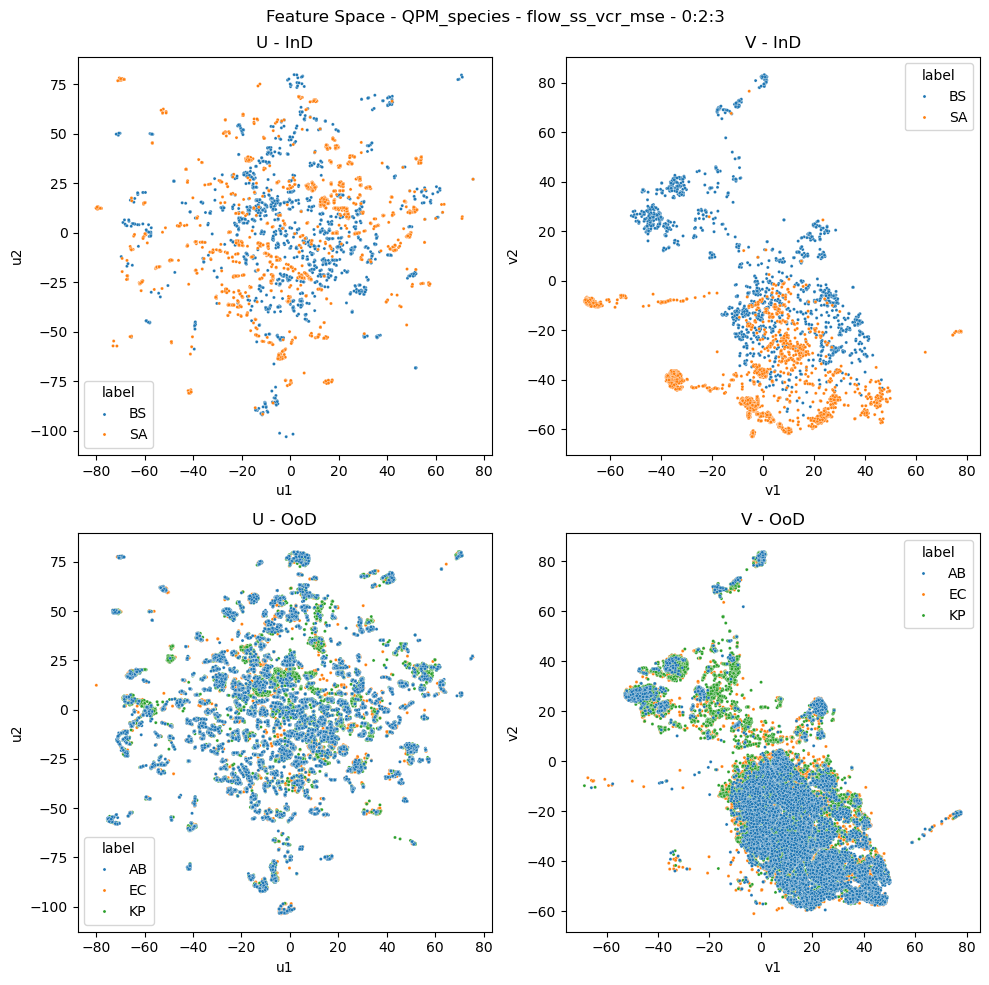

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:02<00:06,  2.11s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:04<00:04,  2.06s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:06<00:02,  2.08s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.17s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.14s/it]

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:11<00:35, 11.76s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:23<00:23, 11.80s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:35<00:11, 11.87s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:47<00:00, 12.00s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:47<00:00, 11.94s/it]

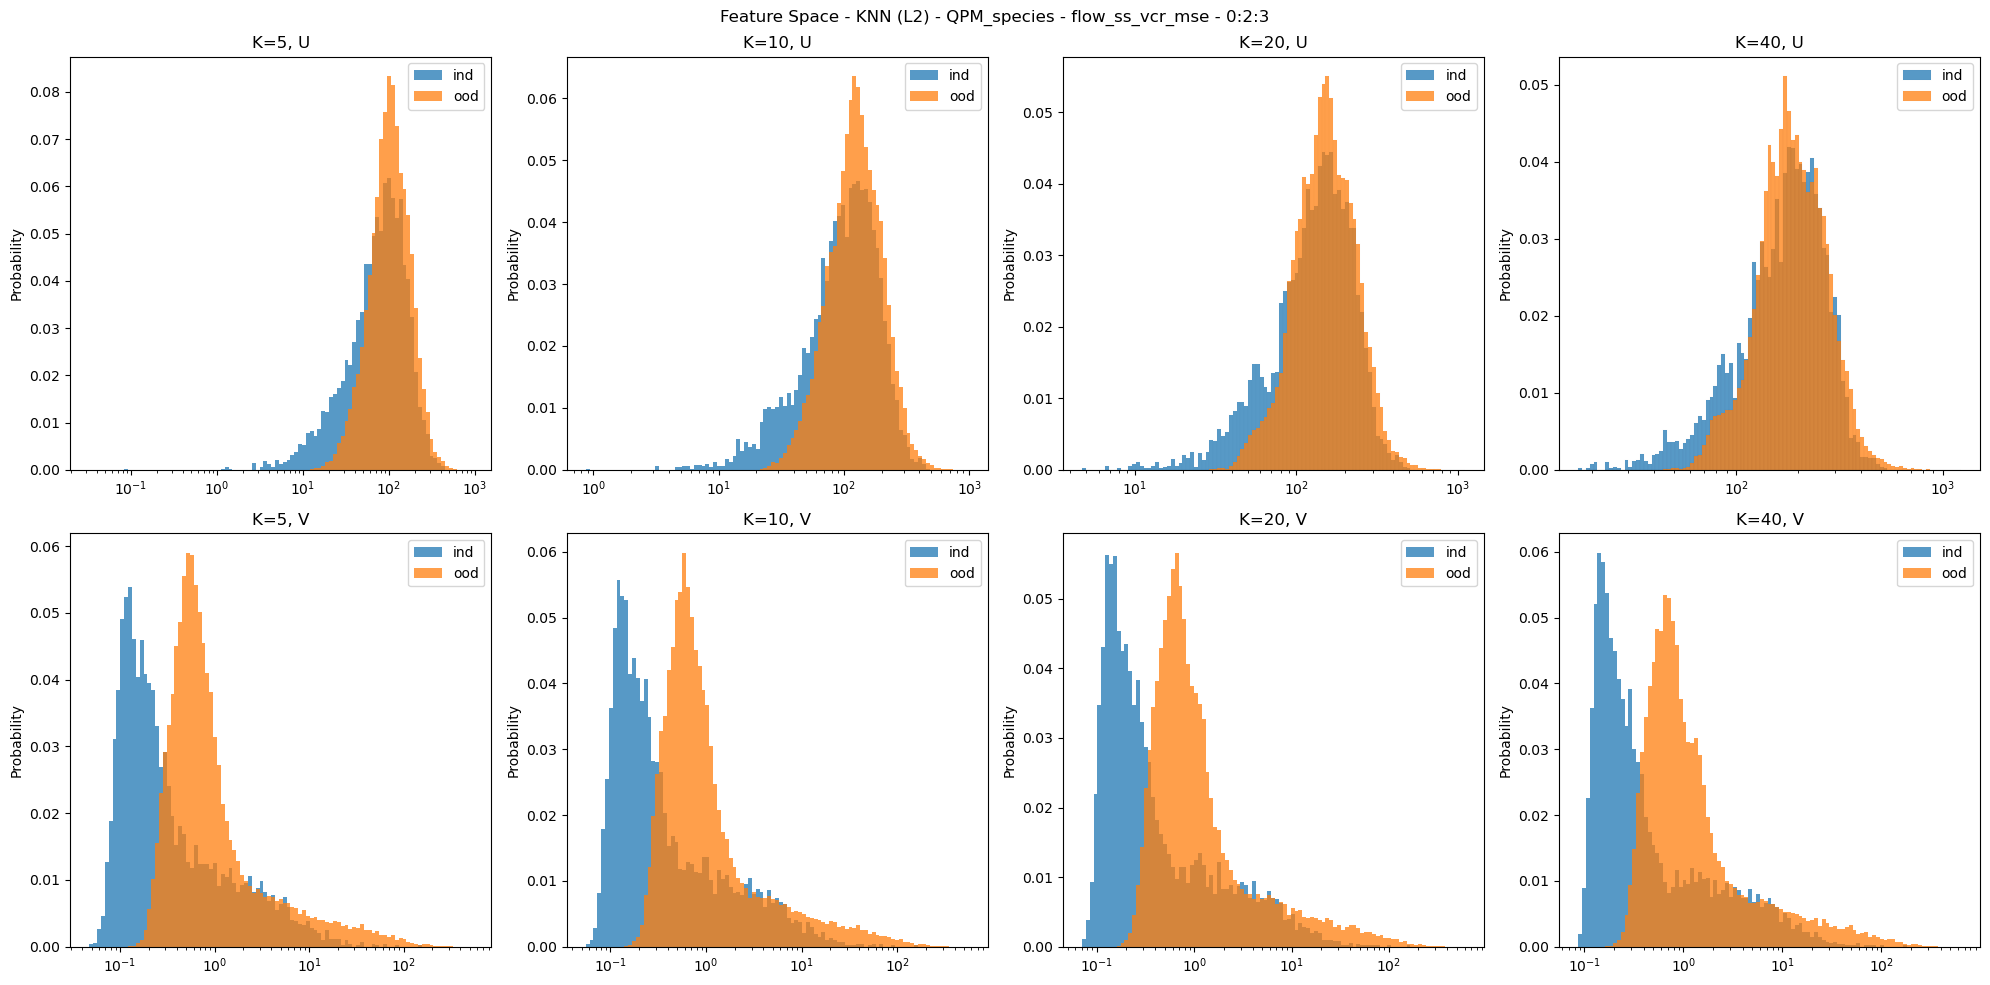

In [13]:
# plot knn to val data in feature space (L2)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatL2(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatL2(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:01<00:05,  1.95s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:03<00:03,  1.97s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:06<00:02,  2.02s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.11s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.06s/it]

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:11<00:35, 11.67s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:23<00:23, 11.83s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:35<00:11, 11.82s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:47<00:00, 11.87s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:47<00:00, 11.84s/it]

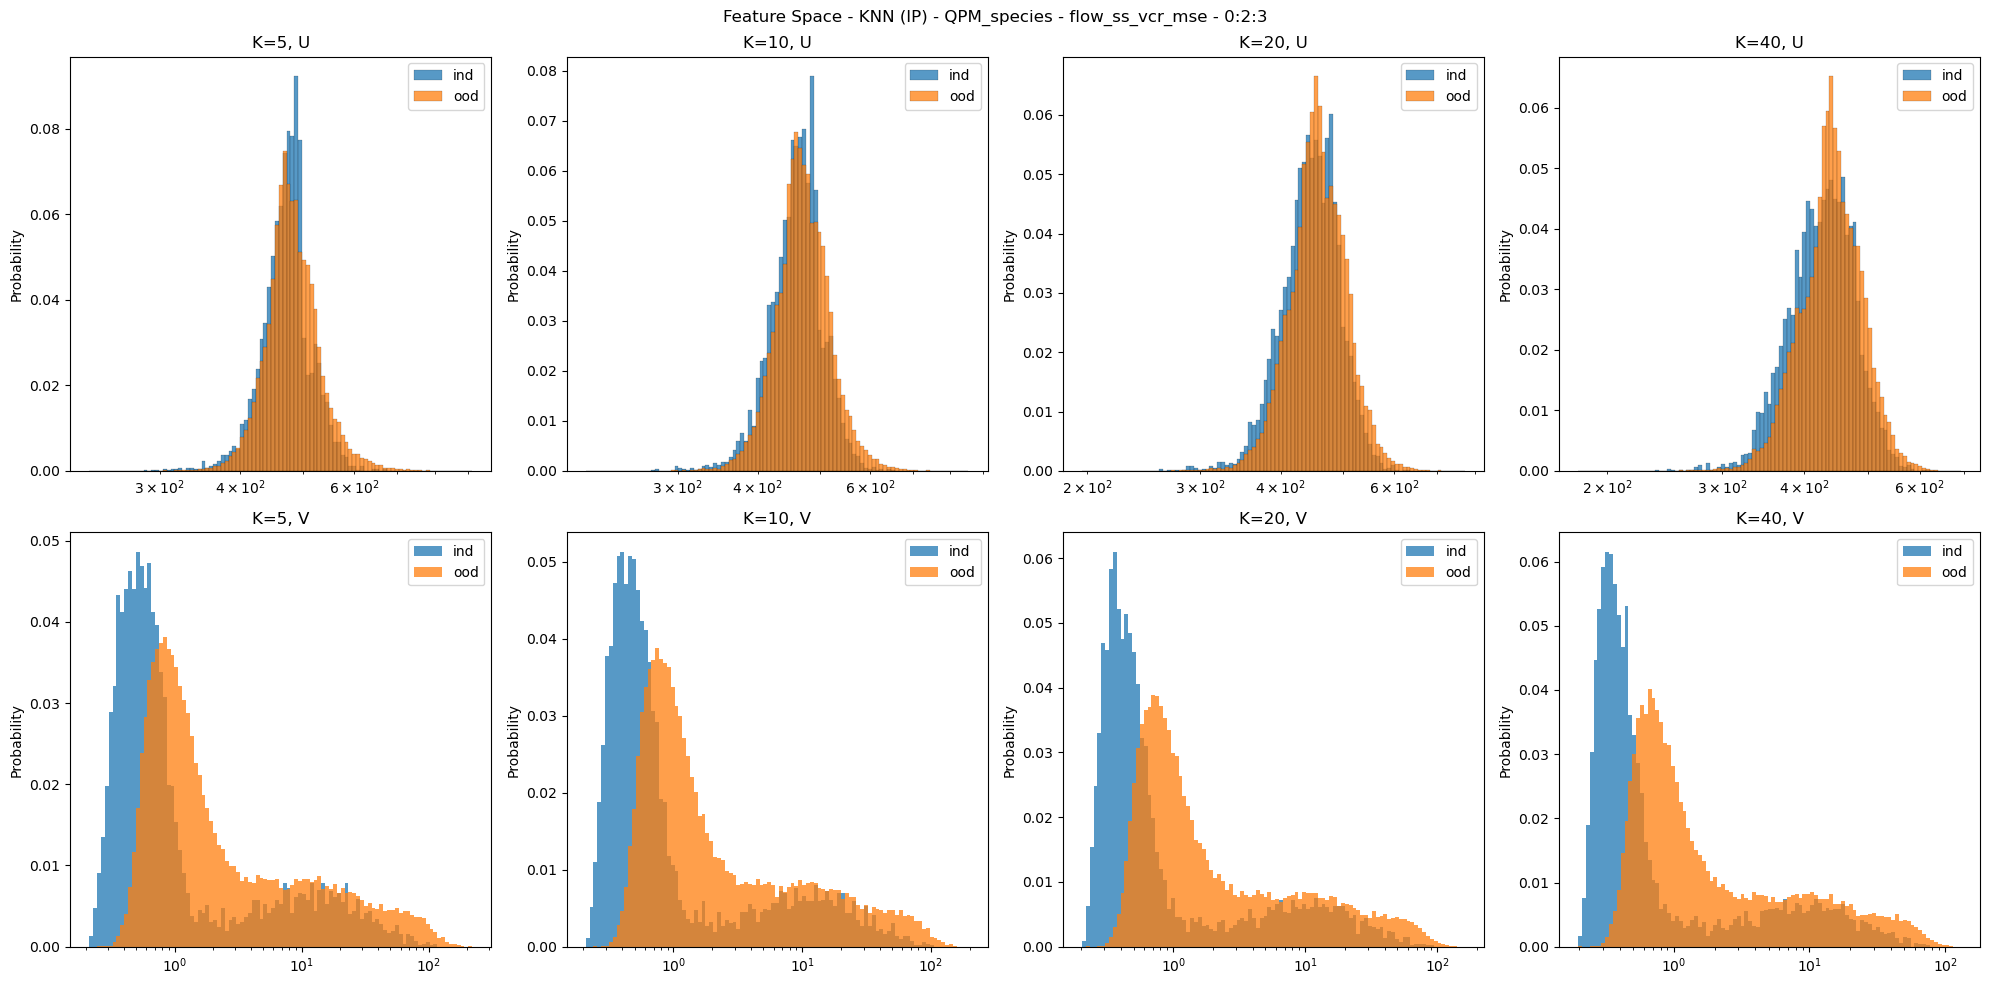

In [14]:
# plot knn to val data in feature space (IP)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatIP(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatIP(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

22.743055 0.7650029 1.2581391 1.3692685
22.684193 0.6822756 1.1462799 1.2093445
22.750027 0.7551634 1.2786431 1.3675613
23.255346 1.2497305 2.0060554 2.2396302
34.56032 0.92047364 58.11449 0.7491844


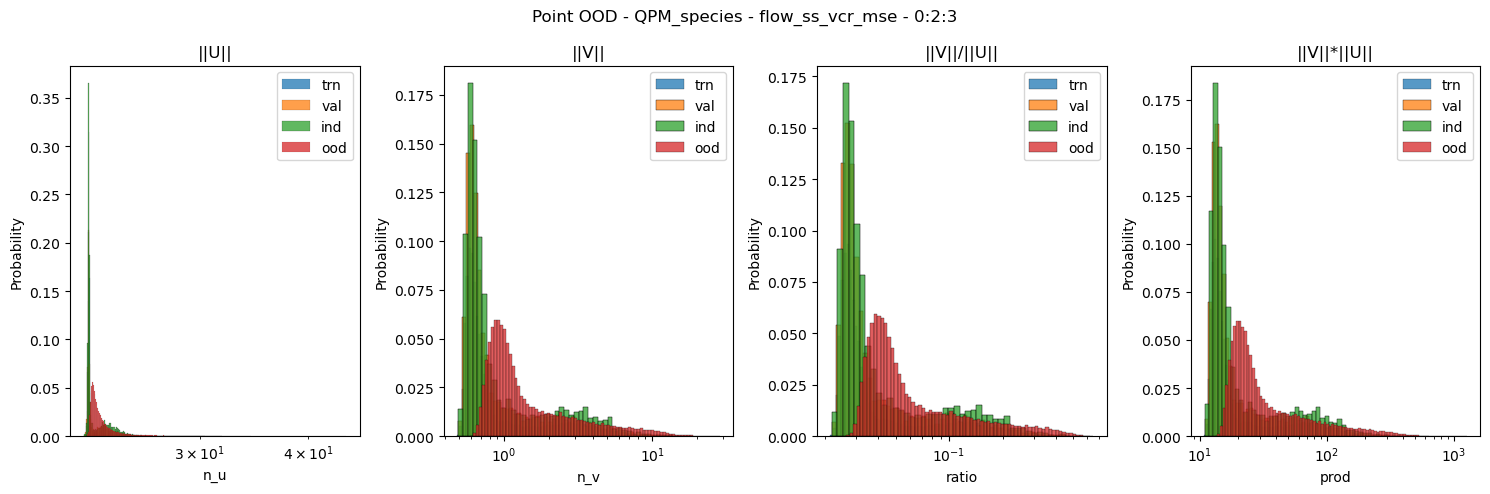

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


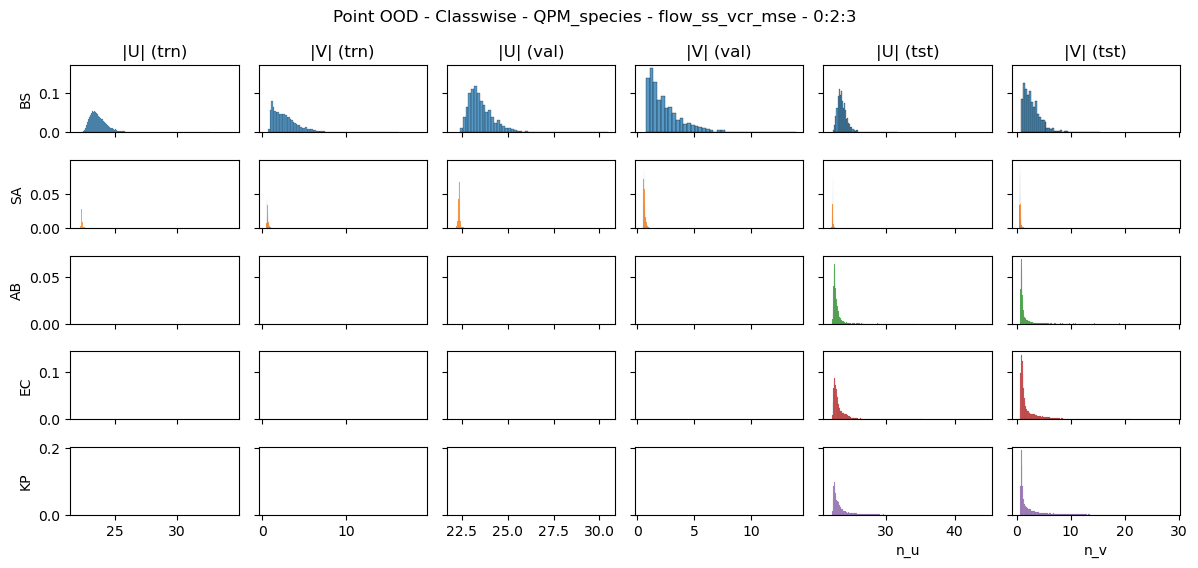

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

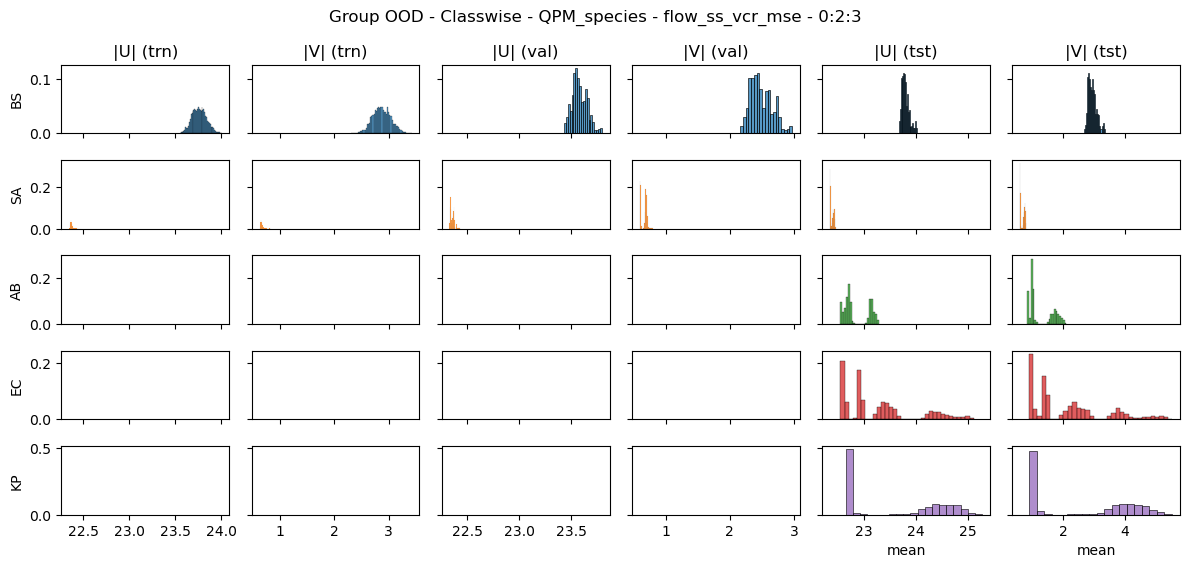

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

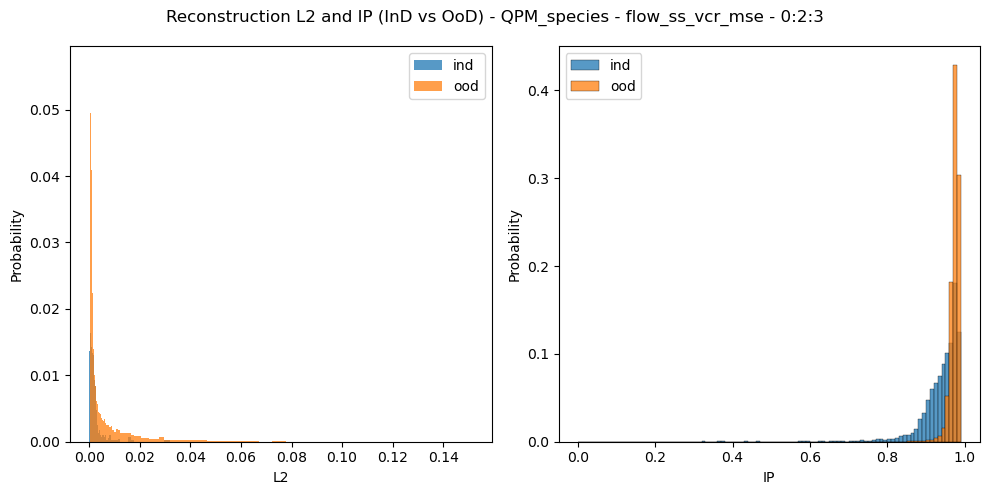

In [20]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)
# store
_df = pd.DataFrame(dict(target=ind_tgt, rcn_l2=ind_rcn_l2, rcn_ip=ind_rcn_ip, source="ind"))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(target=ood_tgt, rcn_l2=ood_rcn_l2, rcn_ip=ood_rcn_ip, source="ood"))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ood", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ood", stat="probability", bins=bins_rcn_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("L2")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()